In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [36]:
csv_files = [
    "negative_testing_spectra_1000_MassSpecGym_hits_20251215_222930.csv",
    "negative_training_spectra_1000_MassSpecGym_hits_20251215_222823.csv",
    "negative_validation_spectra_1000_MassSpecGym_hits_20251215_222718.csv",
    "positive_testing_spectra_1000_MassSpecGym_hits_20251215_222458.csv",
    "positive_training_spectra_1000_MassSpecGym_hits_20251215_222356.csv",
    "positive_validation_spectra_1000_MassSpecGym_hits_20251215_222255.csv",
]

mean_similarities = {}

for f in csv_files:
    df = pd.read_csv(f)
    mean_similarities[f] = df["DreaMS similarity"].mean()

files = list(mean_similarities.keys())
means = [mean_similarities[f] for f in files]

In [37]:
def short_name(filename):
    parts = filename.split('_')
    if len(parts) > 2:
        return '_'.join(parts[:2])
    return filename

short_names = [short_name(f) for f in csv_files]
#print(short_names)

['negative_testing', 'negative_training', 'negative_validation', 'positive_testing', 'positive_training', 'positive_validation']


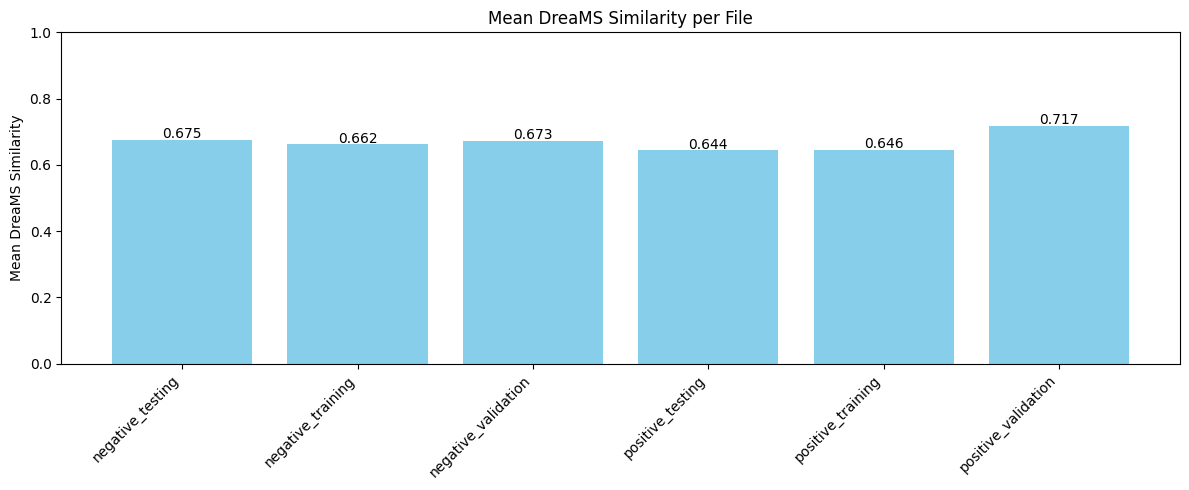

In [62]:
plt.figure(figsize=(12,5))
plt.bar(short_names, means, color='skyblue')
plt.ylabel("Mean DreaMS Similarity")
plt.xticks(rotation=45, ha='right')
plt.title("Mean DreaMS Similarity per File")
plt.ylim(0, 1)

for i, m in enumerate(means):
    plt.text(i, m + 0.005, f"{m:.3f}", ha='center')

plt.tight_layout()
plt.show()

In [41]:
summary_stats = []

for f in csv_files:
    df = pd.read_csv(f)
    sims = df["DreaMS similarity"]
    summary_stats.append({
        "File": short_name(f),
        "Mean Similarity": sims.mean(),
        "Std Similarity": sims.std()
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


                  File  Mean Similarity  Std Similarity
0     negative_testing         0.674707        0.076388
1    negative_training         0.661825        0.086237
2  negative_validation         0.672732        0.081552
3     positive_testing         0.644004        0.088135
4    positive_training         0.645616        0.084299
5  positive_validation         0.717411        0.157692


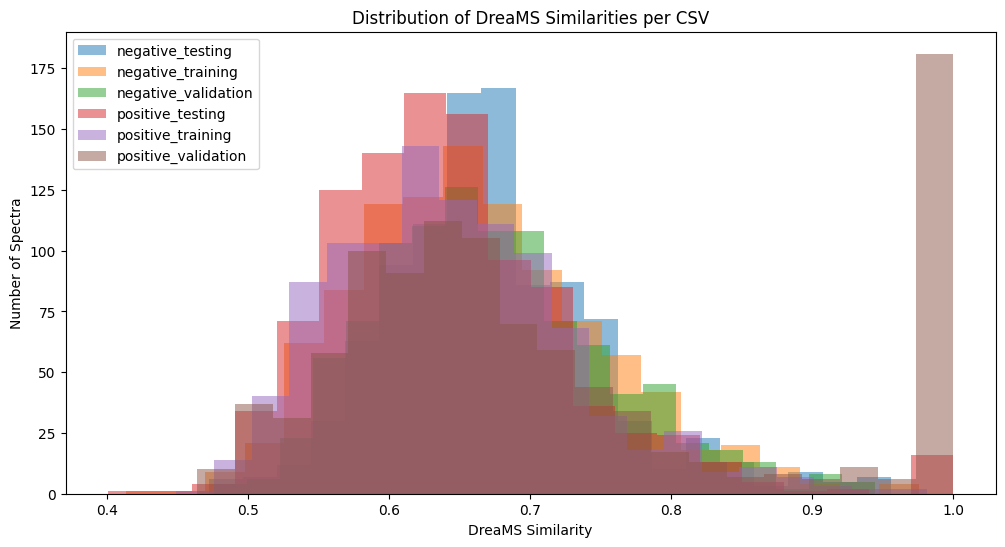

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for f in csv_files:
    df = pd.read_csv(f)
    sims = df["DreaMS similarity"]
    plt.hist(sims, bins=20, alpha=0.5, label=short_name(f))

plt.xlabel("DreaMS Similarity")
plt.ylabel("Number of Spectra")
plt.title("Distribution of DreaMS Similarities per CSV")
plt.legend()
plt.show()

In [58]:
from matchms.importing import load_from_mgf
from ms2deepscore import MS2DeepScore
from ms2deepscore.models import load_model
from matchms.Pipeline import Pipeline, create_workflow
from matchms.filtering.default_pipelines import DEFAULT_FILTERS

In [56]:
import requests
import os
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))

spectrum_file_name = "pesticides.mgf"
download_file("https://raw.githubusercontent.com/matchms/ms2deepscore/refs/heads/main/tests/resources/pesticides_processed.mgf", spectrum_file_name)

In [60]:
mgf_files = [
    "negative_testing_spectra_1000.mgf",
    "negative_training_spectra_1000.mgf",
    "positive_testing_spectra_1000.mgf",
    "positive_training_spectra_1000.mgf",
    "positive_validation_spectra_1000.mgf",
    "negative_validation_spectra_1000.mgf"
]

model = load_model("ms2deepscore_model.pt")
ms2ds_model = MS2DeepScore(model)
pipeline = Pipeline(create_workflow(query_filters=DEFAULT_FILTERS,
                                    score_computations=[[MS2DeepScore, {"model": model}]]))
report = pipeline.run(spectrum_file_name)
library_spectra = pipeline.spectra_queries
library_embeddings = ms2ds_model.get_embedding_array(library_spectra)

2025-12-15 17:27:55,562:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:27:55,571:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:27:55,583:WARNING:matchms:Pipeline:No logging file was defined.Logging messages will not be written to file.


Processing spectra: 76it [00:01, 67.08it/s]
76it [00:01, 43.22it/s]
76it [00:01, 42.89it/s]


In [61]:
embeddings_dict = {}
mean_similarities = {}
std_similarities = {}
all_similarities = {}

for f in mgf_files:
    pipeline = Pipeline(create_workflow(query_filters=DEFAULT_FILTERS,
                                        score_computations=[[MS2DeepScore, {"model": model}]]))
    report = pipeline.run(f)
    cleaned_spectra = pipeline.spectra_queries
    embeddings = ms2ds_model.get_embedding_array(cleaned_spectra)
    embeddings_dict[f] = embeddings

    sim_matrix = np.dot(embeddings, library_embeddings.T) / \
                 (np.linalg.norm(embeddings, axis=1)[:, None] * np.linalg.norm(library_embeddings, axis=1)[None, :])

    best_sims = sim_matrix.max(axis=1)
    mean_similarities[f] = best_sims.mean()
    std_similarities[f] = best_sims.std()
    all_similarities[f] = best_sims

2025-12-15 17:28:28,669:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:28:28,672:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:28:28,674:WARNING:matchms:Pipeline:No logging file was defined.Logging messages will not be written to file.


Processing spectra: 1000it [00:13, 72.21it/s]
1000it [00:22, 44.33it/s]
1000it [00:22, 45.23it/s]

2025-12-15 17:29:27,595:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:29:27,596:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:29:27,601:WARNING:matchms:Pipeline:No logging file was defined.Logging messages will not be written to file.



Processing spectra: 1000it [00:14, 67.91it/s]
1000it [00:22, 44.57it/s]
1000it [00:20, 48.68it/s]

2025-12-15 17:30:25,671:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:30:25,674:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:30:25,678:WARNING:matchms:Pipeline:No logging file was defined.Logging messages will not be written to file.



Processing spectra: 1000it [00:16, 61.58it/s]
1000it [00:22, 45.28it/s]
1000it [00:23, 42.59it/s]

2025-12-15 17:31:27,888:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:31:27,892:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:31:27,898:WARNING:matchms:Pipeline:No logging file was defined.Logging messages will not be written to file.



Processing spectra: 171it [00:02, 62.16it/s]

2025-12-15 17:31:30,841:WARNING:matchms:clean_adduct:The charge in the adduct: [M-H2O+H]+ and the given charge: 2 do not match
2025-12-15 17:31:30,865:WARNING:matchms:clean_adduct:The charge in the adduct: [M-H2O+H]+ and the given charge: 2 do not match


Processing spectra: 178it [00:02, 54.44it/s]

2025-12-15 17:31:30,886:WARNING:matchms:clean_adduct:The charge in the adduct: [M-H2O+H]+ and the given charge: 2 do not match


Processing spectra: 1000it [00:17, 56.82it/s]
1000it [00:20, 48.57it/s]
1000it [00:21, 46.79it/s]

2025-12-15 17:32:27,847:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:32:27,850:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:32:27,855:WARNING:matchms:Pipeline:No logging file was defined.Logging messages will not be written to file.



Processing spectra: 397it [00:06, 62.10it/s]

2025-12-15 17:32:34,926:WARNING:matchms:clean_adduct:The charge in the adduct: [M-H2O+H]+ and the given charge: 2 do not match


Processing spectra: 404it [00:07, 60.50it/s]

2025-12-15 17:32:34,956:WARNING:matchms:clean_adduct:The charge in the adduct: [M-H2O+H]+ and the given charge: 2 do not match
2025-12-15 17:32:34,981:WARNING:matchms:clean_adduct:The charge in the adduct: [M-H2O+H]+ and the given charge: 2 do not match


Processing spectra: 1000it [00:16, 60.84it/s]
1000it [00:21, 46.10it/s]
1000it [00:20, 48.72it/s]

2025-12-15 17:33:26,885:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:33:26,888:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2025-12-15 17:33:26,894:WARNING:matchms:Pipeline:No logging file was defined.Logging messages will not be written to file.



Processing spectra: 1000it [00:14, 71.02it/s]
1000it [00:22, 44.81it/s]
1000it [00:21, 46.69it/s]


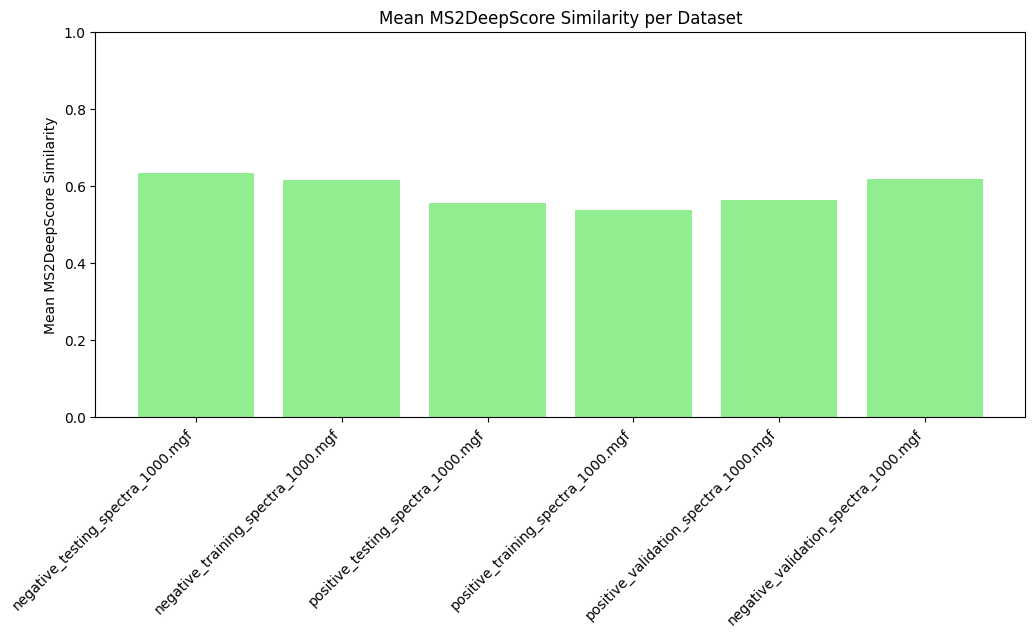

In [63]:
files = list(mean_similarities.keys())
means = [mean_similarities[f] for f in files]

plt.figure(figsize=(12,5))
plt.bar(files, means, color='lightgreen')
plt.ylabel("Mean MS2DeepScore Similarity")
plt.xticks(rotation=45, ha='right')
plt.title("Mean MS2DeepScore Similarity per Dataset")
plt.ylim(0, 1)
plt.show()

In [68]:
summary_df = pd.DataFrame({
    "File": files,
    "Mean Similarity": [mean_similarities[f] for f in files],
    "Std Similarity": [std_similarities[f] for f in files]
})
print(summary_df)

                                   File  Mean Similarity  Std Similarity
0     negative_testing_spectra_1000.mgf         0.633210        0.102151
1    negative_training_spectra_1000.mgf         0.613781        0.110850
2     positive_testing_spectra_1000.mgf         0.555275        0.071958
3    positive_training_spectra_1000.mgf         0.537029        0.066330
4  positive_validation_spectra_1000.mgf         0.562570        0.073118
5  negative_validation_spectra_1000.mgf         0.616921        0.114745


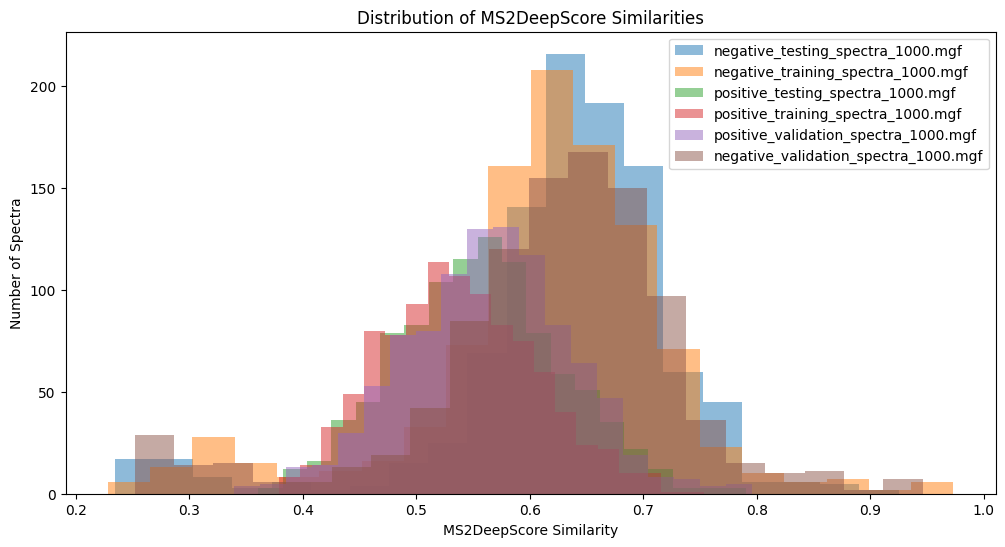

In [69]:
plt.figure(figsize=(12,6))
for f in files:
    plt.hist(all_similarities[f], bins=20, alpha=0.5, label=f)
plt.xlabel("MS2DeepScore Similarity")
plt.ylabel("Number of Spectra")
plt.title("Distribution of MS2DeepScore Similarities")
plt.legend()
plt.show()